In [13]:
import xarray as xr
from cdo import Cdo
cdo = Cdo()
herold_file = "/lus/h2resw01/hpcperm/ccpd/Herold_etal_2014/herold_etal_eocene_biome_1x1.nc"
herold_remap = cdo.remapnn("N32", input=herold_file, output="/lus/h2resw01/hpcperm/ccpd/Herold_etal_2014/herold_etal_eocene_biome_1x1_N32.nc")

icmgg_file = "/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT"
icmgg_remap = cdo.setgridtype("regularnn", input=icmgg_file, output="/lus/h2resw01/hpcperm/ccpd/Herold_etal_2014/ICMGG.nc", options="-f nc --eccodes")

herold = xr.open_dataset(herold_remap)
icmgg = xr.open_dataset(icmgg_remap)


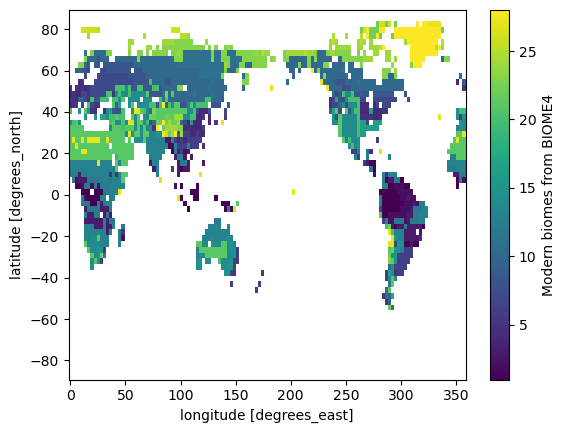

In [6]:
herold["prei_biome"].plot()

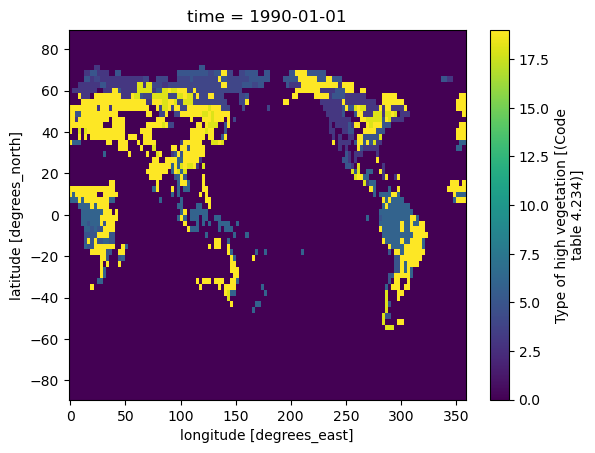

In [46]:
icmgg['tvh'].plot()

In [47]:
hp_dict = {
    '1': 'tropical forest',
    '2': 'warm temperate forest',
    '3': 'temperate forest',
    '4': 'boreal forest',
    '5': 'savana',
    '6': 'grassland',
    '7': 'desert',
    '8': 'dry tundra',
    '9': 'tundra',
    '10': 'ice',
}

land_cover_types = {
    0: "No vegetation",
    1: "Crops, Mixed farming",
    2: "Grass",
    3: "Evergreen needleleaf trees",
    4: "Deciduous needleleaf trees",
    5: "Deciduous broadleaf trees",
    6: "Evergreen broadleaf trees",
    7: "Tall grass",
    8: "Desert",
    9: "Tundra",
    10: "Irrigated crops",
    11: "Semidesert",
    12: "Ice caps and Glaciers",
    13: "Bogs and marshes",
    14: "Inland water",
    15: "Ocean",
    16: "Evergreen shrubs",
    17: "Deciduous shrubs",
    18: "Mixed forest/woodland",
    19: "Interrupted forest",
    20: "Water and land mixtures"
}

#herold["prei_biome"].where(herold["prei_biome"] == 1).plot()
import numpy as np
biome_dict = {'tvh': {}, 'tvl': {}}
for vegtype in ["tvh", "tvl"]:
    for i in range(1, 11):
        vegid = icmgg[vegtype].where(herold["prei_biome_hp"] == i).values
        vegid = vegid[~np.isnan(vegid)]
        unique, counts = np.unique(vegid, return_counts=True)
        if unique.size>0:
            biome_dict[vegtype][i] = int(unique[np.argmax(counts)])
        else:
            biome_dict[vegtype][i] = None

for key in hp_dict:
    print(f"{hp_dict[key]} -> {land_cover_types[biome_dict['tvh'][int(key)]]} and {land_cover_types[biome_dict['tvl'][int(key)]]}")



tropical forest -> Evergreen broadleaf trees and Tall grass
warm temperate forest -> Interrupted forest and Crops, Mixed farming
temperate forest -> Interrupted forest and Crops, Mixed farming
boreal forest -> Deciduous needleleaf trees and Tundra
savana -> Interrupted forest and Tall grass
grassland -> Interrupted forest and Semidesert
desert -> No vegetation and Semidesert
dry tundra -> No vegetation and Semidesert
tundra -> No vegetation and Tundra
ice -> No vegetation and No vegetation


In [49]:
biome_dict

{'tvh': {1: 6, 2: 19, 3: 19, 4: 4, 5: 19, 6: 19, 7: 0, 8: 0, 9: 0, 10: 0},
 'tvl': {1: 7, 2: 1, 3: 1, 4: 9, 5: 7, 6: 11, 7: 11, 8: 11, 9: 9, 10: 0}}

In [53]:
herold['eocene_biome_hp'] == 1

<xarray.DataArray 'eocene_biome_hp' (lat: 64, lon: 128)> Size: 8kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(64, 128))
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86

In [58]:
import copy

eocene_icmgg = copy.deepcopy(icmgg)
for vegtype in ["tvh", "tvl"]:
    eocene_icmgg[vegtype] = eocene_icmgg[vegtype]*0
    for i in range(1, 11):
        eocene_icmgg[vegtype] = xr.where(herold['eocene_biome_hp'] == i, biome_dict[vegtype][i], eocene_icmgg[vegtype])



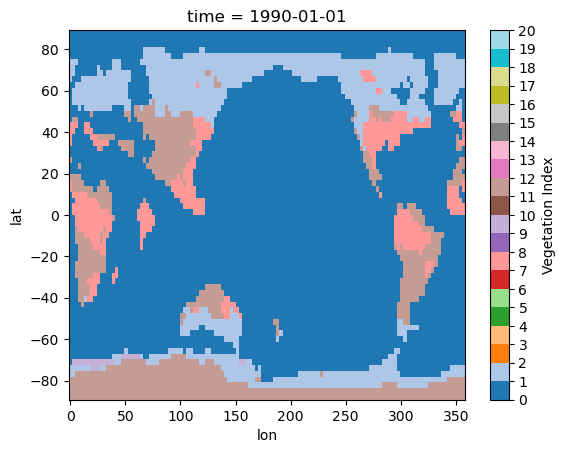

In [60]:


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm
# Group every 2 values: 0-1, 2-3, ..., 18-19
bounds = np.arange(21)  # from 0 to 20, step 2 (note 22 to include upper bound)
ncolors = len(bounds) - 1
# Use a categorical colormap with enough colors
cmap = plt.get_cmap('tab20', ncolors)  # tab20 has 20 distinct colors
norm = BoundaryNorm(bounds, ncolors)
eocene_icmgg['tvl'].plot(
    cmap=cmap,
    norm=norm,
    cbar_kwargs={'ticks': bounds, 'label': 'Vegetation Index'})
